## Исследование выручки авикомпании

<b>Задача:</b>
Исследование доходов авиакомпаний по направлениям полетов, типам рейсов, сезонности продаж<br>

<b>Дополнительный источник данных:</b><br>
https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

## Обработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm, spearmanr, kendalltau
from scipy import stats as st

In [2]:
#загрузим детасет 
df = pd.read_csv('air_data.csv', sep=';')
df.head(4)

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28 00:00:00,2022-01-04 00:00:00,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE
3,2021-12-08 00:00:00,2022-01-05 00:00:00,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE


In [3]:
#посмотрим на названия столбцов
df.columns

Index(['ISSUE_DATE', 'FLIGHT_DATE_LOC', 'PAX_TYPE', 'REVENUE_AMOUNT',
       'ORIG_CITY_CODE', 'DEST_CITY_CODE', 'ROUTE_FLIGHT_TYPE', 'FFP_FLAG',
       'SALE_TYPE'],
      dtype='object')

In [4]:
#приведем названия столбцов к строчному виду
df.columns = df.columns.str.lower() 

In [5]:
#проверка
df.columns

Index(['issue_date', 'flight_date_loc', 'pax_type', 'revenue_amount',
       'orig_city_code', 'dest_city_code', 'route_flight_type', 'ffp_flag',
       'sale_type'],
      dtype='object')

### 2.2. Проверьте типы данных.

In [6]:
#посмртрим общую информацию о детасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   issue_date         50000 non-null  object
 1   flight_date_loc    50000 non-null  object
 2   pax_type           50000 non-null  object
 3   revenue_amount     50000 non-null  int64 
 4   orig_city_code     49998 non-null  object
 5   dest_city_code     49999 non-null  object
 6   route_flight_type  50000 non-null  object
 7   ffp_flag           19398 non-null  object
 8   sale_type          50000 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB


Таким образом, в детасете содержится 50000 строк и 9 столбцов. В трех столбцах (Orig_city_code, Dest_city_code, Ffp_flag) есть пропуски. Кроме того, в первых двух столбцах, где содержится дата, необходимо изменить тип данных на необходимый нам. 

In [7]:
#сменим тип данных для столбца Flight_date_loc и Issue_date
df['issue_date'] = pd.to_datetime(df['issue_date'], format='%Y-%m-%d %H:%M:%S')
df['flight_date_loc'] = pd.to_datetime(df['flight_date_loc'], format='%Y-%m-%d %H:%M:%S')

In [8]:
#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   issue_date         50000 non-null  datetime64[ns]
 1   flight_date_loc    50000 non-null  datetime64[ns]
 2   pax_type           50000 non-null  object        
 3   revenue_amount     50000 non-null  int64         
 4   orig_city_code     49998 non-null  object        
 5   dest_city_code     49999 non-null  object        
 6   route_flight_type  50000 non-null  object        
 7   ffp_flag           19398 non-null  object        
 8   sale_type          50000 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 3.4+ MB


### 2.3. Обработайте пропуски.

In [9]:
df.isna().sum() #найдем количество пропусков

issue_date               0
flight_date_loc          0
pax_type                 0
revenue_amount           0
orig_city_code           2
dest_city_code           1
route_flight_type        0
ffp_flag             30602
sale_type                0
dtype: int64

In [10]:
#посмотрим на строки с пропусками по столбцу Orig_city_code 
df[df['orig_city_code'].isna()]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
2020,2022-02-17,2022-03-22,AD,440,NaN,KHV,МВЛ,NaN,ONLINE
8100,2022-05-02,2022-05-11,AD,440,NaN,KHV,МВЛ,NaN,OFFLINE


К сожалению, поиск соответствий по дате рейса и городу прибытия ничего не дал, и данные восстановить не удалось. Поскольку таких строчек всего две их можно удалить без значительной потери данных. 

In [11]:
#удалим из детасета эти строки
df = df.drop(labels = [2020, 8100], axis = 0)

In [12]:
#посмотрим на строки с пропусками по столбцу Dest_city_code
df[df['dest_city_code'].isna()]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
47582,2022-05-13,2022-07-28,AD,440,KHV,NaN,МВЛ,NaN,OFFLINE


К сожалению, поиск соответствий по дате рейса и городу отправления ничего не дал, и данные восстановить не удалось. Поскольку таких строчек всего одна их можно удалить без значительной потери данных.

In [13]:
#удалим из детасета эти строки
df = df.drop(labels = [47582], axis = 0)

In [14]:
#посмотрим на строки с пропусками по столбцу Ffp_flag
df[df['ffp_flag'].isna()]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
5,2021-11-29,2022-01-14,AD,250,MOW,DUS,МВЛ,NaN,ONLINE
9,2021-11-25,2022-01-03,AD,280,MOW,KUF,ВВЛ,NaN,ONLINE
...,...,...,...,...,...,...,...,...,...
49992,2022-06-22,2022-06-28,AD,810,MOW,BTK,ВВЛ,NaN,OFFLINE
49994,2022-06-27,2022-06-28,AD,450,OVB,LED,ВВЛ,NaN,OFFLINE
49995,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,NaN,ONLINE
49996,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,NaN,OFFLINE


In [15]:
#посмотрим уникальные значения по этому столбцу
df['ffp_flag'].unique()

array([nan, 'FFP'], dtype=object)

In [16]:
#заменим FFP на Yes, согласно описанию столбца, а NaN - на No
df['ffp_flag'] = df['ffp_flag'].replace({'FFP':'Yes'}, regex=True)
df['ffp_flag'] = df['ffp_flag'].fillna('No')

In [17]:
#проверка
df['ffp_flag'].unique()

array(['No', 'Yes'], dtype=object)

Проверим оставшиеся столбцы на уникальные значения, чтобы исключить возможные ошибки в данных (лишние пробелы и похожие записи одного и того же слова)

In [18]:
df['pax_type'].unique()

array(['AD', 'CHD', 'INF'], dtype=object)

In [19]:
df['orig_city_code'].unique()

array(['MOW', 'UUS', 'KGD', 'VOZ', 'OVB', 'KZN', 'PEZ', 'UUD', 'GDZ',
       'TAS', 'SVX', 'OMS', 'LED', 'OGZ', 'AER', 'UFA', 'EGO', 'KRR',
       'KEJ', 'KUF', 'LBD', 'NUX', 'IKT', 'BOJ', 'DXB', 'KJA', 'AAQ',
       'TOF', 'LPK', 'SGC', 'AYT', 'HRG', 'VAR', 'MJZ', 'SIP', 'ROV',
       'BKK', 'MMK', 'KIV', 'PAR', 'BTK', 'KVK', 'PEE', 'RTW', 'NER',
       'NOZ', 'MCX', 'GOJ', 'NJC', 'MQF', 'SSH', 'YKS', 'BQS', 'IWA',
       'VVO', 'PKC', 'ABA', 'NOJ', 'CEK', 'HKT', 'BAK', 'VOG', 'ULY',
       'TLK', 'NSK', 'KSQ', 'KQT', 'MUC', 'FEG', 'ROM', 'ALA', 'MRV',
       'HTA', 'UGC', 'STW', 'GDX', 'OSS', 'ASF', 'KHV', 'MSQ', 'RGK',
       'TJM', 'DYR', 'IAR', 'BAX', 'ALC', 'DYU', 'SEL', 'CRZ', 'EVN',
       'HER', 'NCE', 'LCA', 'LWN', 'UKK', 'BHK', 'NYM', 'IKU', 'NMA',
       'BER', 'FRU', 'GRV', 'REN', 'SKD', 'BZK', 'NVI', 'BCN', 'SLY',
       'HAJ', 'PFO', 'PUY', 'NQZ', 'NBC', 'TLV', 'HMA', 'PYJ', 'IJK',
       'KXK', 'TJU', 'DOH', 'JED', 'OHH', 'RKT', 'BAH', 'SKG', 'DUS',
       'IST', 'BLQ',

In [20]:
df['dest_city_code'].unique()

array(['KGD', 'OVB', 'MOW', 'KRR', 'DUS', 'PEE', 'AER', 'NJC', 'KUF',
       'UUD', 'HEL', 'LED', 'ABA', 'EVN', 'GDZ', 'KZN', 'MRV', 'SIP',
       'SKG', 'FEG', 'MQF', 'VOG', 'HKT', 'CEK', 'RTW', 'IKT', 'ULY',
       'NUX', 'TOF', 'DXB', 'YKS', 'KHV', 'UUS', 'BQS', 'SVX', 'PKC',
       'SGC', 'IJK', 'OGZ', 'AAQ', 'MMK', 'UFA', 'KJA', 'KIV', 'NOZ',
       'BAK', 'CGN', 'ROV', 'NER', 'EGO', 'KEJ', 'TLK', 'VIE', 'BAX',
       'PEZ', 'HTA', 'STW', 'GDX', 'VVO', 'AYT', 'RGK', 'VRN', 'TAS',
       'BLQ', 'TOX', 'BTK', 'NSK', 'OSS', 'GOJ', 'ASF', 'SSH', 'DYU',
       'OMS', 'VOZ', 'SEL', 'FRU', 'LBD', 'MCX', 'HAJ', 'MJZ', 'PFO',
       'HRG', 'BOJ', 'GRV', 'DYR', 'IWA', 'NOJ', 'NYM', 'NVI', 'KQT',
       'RKT', 'UGC', 'TJM', 'HMA', 'BER', 'PWQ', 'BKK', 'LPK', 'INN',
       'NMA', 'KSQ', 'LWN', 'MSQ', 'KVK', 'REN', 'IKU', 'TJU', 'BHK',
       'AUH', 'VAR', 'NQZ', 'ATH', 'ROM', 'LCA', 'TLV', 'UKK', 'BZK',
       'PYJ', 'PUY', 'ALC', 'DOH', 'RIX', 'KXK', 'SLY', 'PAR', 'NBC',
       'SKD', 'MUC',

In [21]:
df['route_flight_type'].unique()

array(['ВВЛ', 'МВЛ'], dtype=object)

In [22]:
df['sale_type'].unique()

array(['ONLINE', 'OFFLINE'], dtype=object)

Эта проверка показала, что в остальных столбцах с исходными данными проблем нет. Можно дальше продолжать наше исследование. 

### 2.4. Проверьте наличие дубликатов.

In [23]:
#посчитаем сумму дубликатов 
df.duplicated().sum()

169

In [24]:
#удалим дубликаты из детасета
df = df.drop_duplicates()

2.5. Исключите нулевые значения в выручке для дальнейшего исследования.

In [25]:
#исключим из детасета строки с нулями в столбце Revenue_amount
df = df[df['revenue_amount'] != 0]

In [26]:
df

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,No,OFFLINE
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,Yes,ONLINE
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,No,ONLINE
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE
...,...,...,...,...,...,...,...,...,...
49995,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,No,ONLINE
49996,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,No,OFFLINE
49997,2022-06-26,2022-06-29,AD,230,MOW,KZN,ВВЛ,Yes,ONLINE
49998,2022-06-26,2022-06-28,AD,270,KZN,MOW,ВВЛ,No,OFFLINE


Таким образом, к концу предобработки данных у нас осталось 49362 из 50000 строк после удаления дубликатов и пустых значений в столбцах, были переимнованы заголовки для удобства, а также заполнены пропуски в столбце Ffp_flag. Данные готовы для дальнейшей работы с ними. 

In [27]:
#установим тему для графиков
sns.set_theme(style="whitegrid", palette='dark:salmon_r')

In [28]:
#зададим размер графиков 
plt.rcParams['figure.figsize'] = (10, 6)

## Исследовательский анализ

### 3.1. Создайте отчет о динамике продаж (выручке). Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.

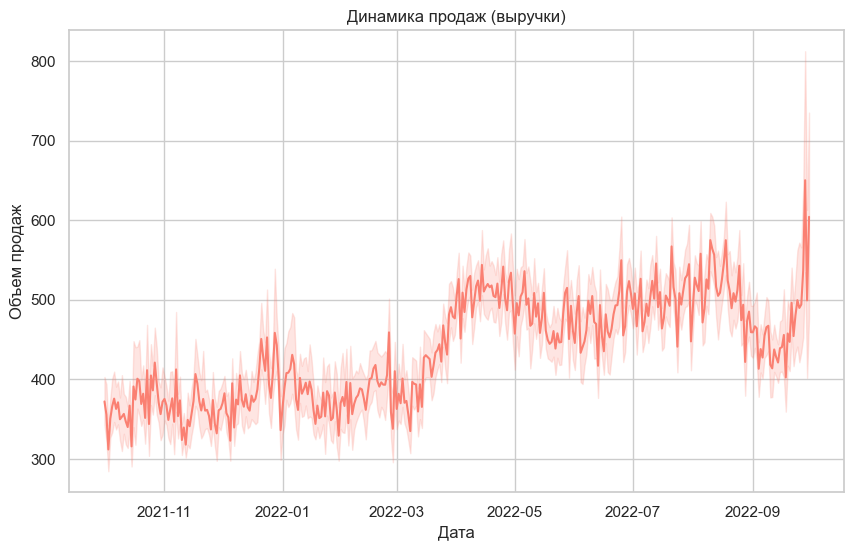

In [47]:
#построим линейный график по дате совершения покупки билета - принесения выручки авиакомпании
sns.lineplot(data=df, x='issue_date', y='revenue_amount').set(title='Динамика продаж (выручки)',
                                                                 xlabel='Дата', 
                                                                 ylabel='Объем продаж')
plt.show()

По графику в целом видна скачкообразная тенденция изменения динамики выручки авикомпании, но для более приятного восприятия укрупним интервалы до месяцев. 

In [29]:
#вытащим из даты покупки  в отдельный столбец год
df['year'] = df['issue_date'].dt.year
#вытащим из даты покупки  в отдельный столбец месяц
df['month'] = df['issue_date'].dt.month
#склеим месяц и год в отдельный столбец месяц для дальнейщего исследования
df['month_year'] = df['month'].astype('str') +'.'+ df['year'].astype('str')
df

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,12.2021
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,No,OFFLINE,2021,12,12.2021
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,Yes,ONLINE,2021,11,11.2021
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,No,ONLINE,2021,12,12.2021
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE,2021,12,12.2021
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,No,ONLINE,2022,6,6.2022
49996,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,No,OFFLINE,2022,6,6.2022
49997,2022-06-26,2022-06-29,AD,230,MOW,KZN,ВВЛ,Yes,ONLINE,2022,6,6.2022
49998,2022-06-26,2022-06-28,AD,270,KZN,MOW,ВВЛ,No,OFFLINE,2022,6,6.2022


In [30]:
#изменим формат столбца Month_Year на формат для времени
df['month_year'] = pd.to_datetime(df['month_year'], format='%m.%Y')

In [31]:
#создадим сводную таблицу с данными о размере выручки по месяцам
df_month_year = df.pivot_table(index='month_year', aggfunc='sum',values='revenue_amount').sort_values (by = 'month_year', ascending=True).reset_index()
df_month_year

,month_year,revenue_amount
0,2021-10-01,1327840
1,2021-11-01,1851260
2,2021-12-01,1757250
3,2022-01-01,1352390
4,2022-02-01,1347770
5,2022-03-01,1826430
6,2022-04-01,2032570
7,2022-05-01,1713360
8,2022-06-01,1614500
9,2022-07-01,2638430


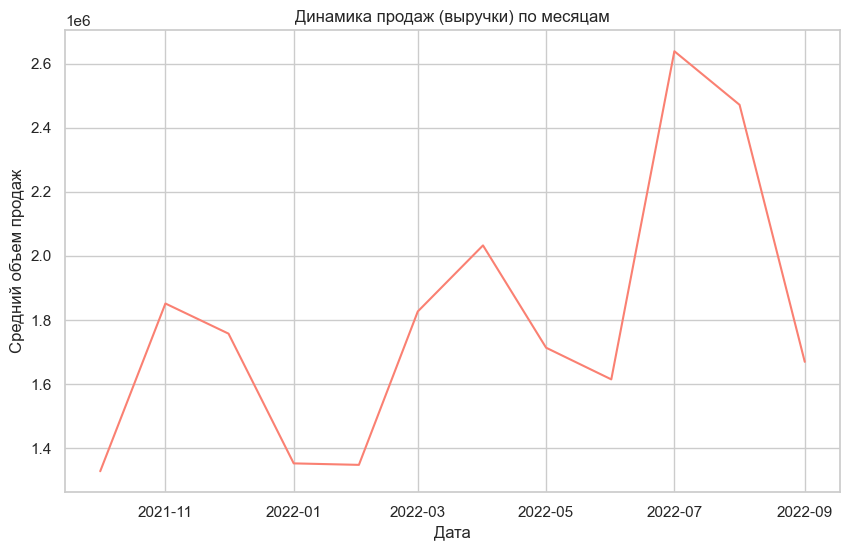

In [48]:
#построим линейный график по дате совершения покупки билета - принесения выручки авиакомпании по этой сводной таблице
sns.lineplot(data=df_month_year, x='month_year', y='revenue_amount').set(title='Динамика продаж (выручки) по месяцам',
                                                                 xlabel='Дата', 
                                                                 ylabel='Средний объем продаж')
plt.show()

Как можно заметить, изменение выручки авикомпании имеет довольно резкий скачкообразный характер: переоды резкого роста сменяются рекими спадами. Пиковые значения мнимума по выручке компания достигла в октябре 2021, феврале 2022 и июне 2022.

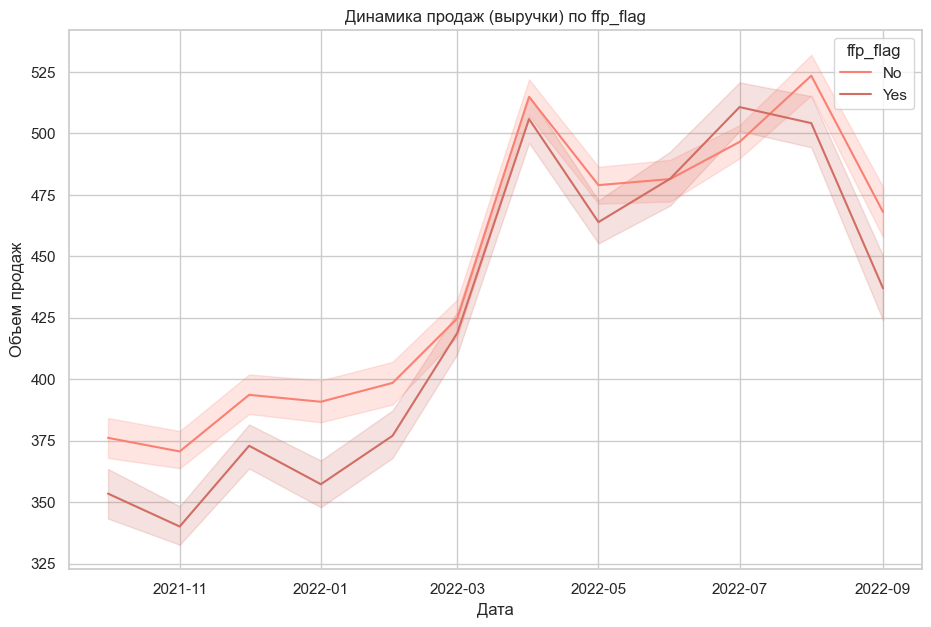

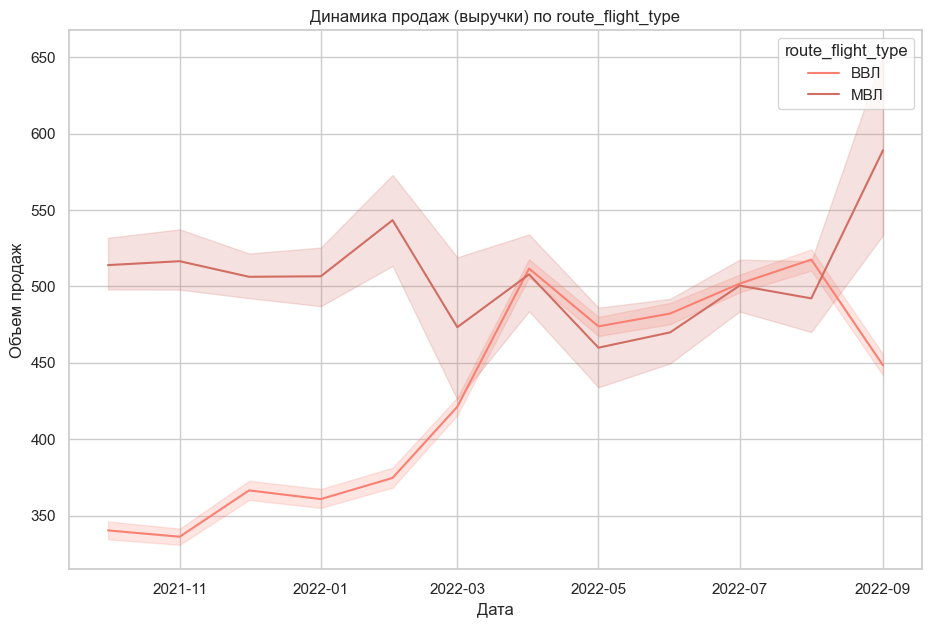

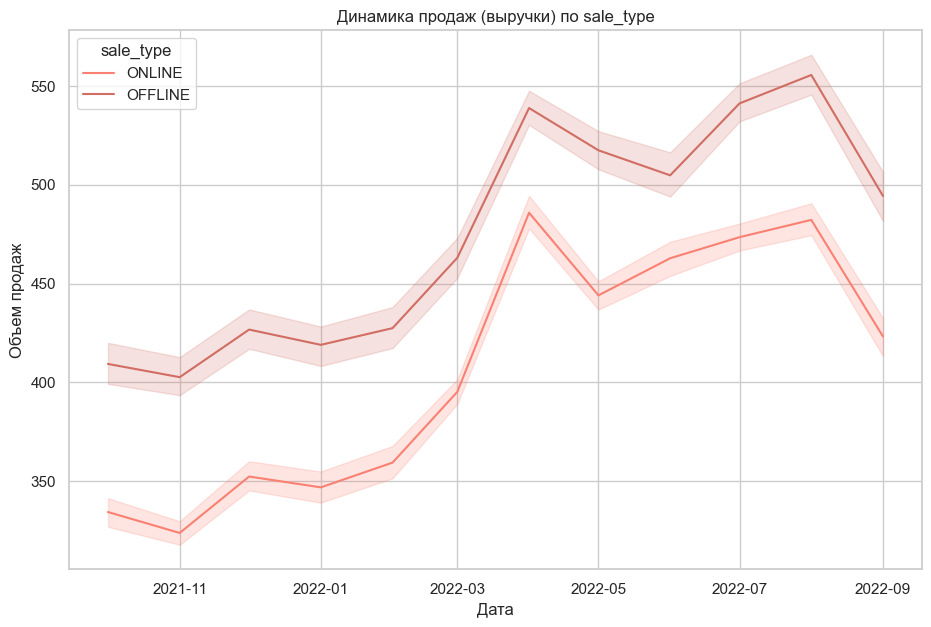

In [36]:
list_1 = ['ffp_flag', 'route_flight_type', 'sale_type']
for i in list_1:
    sns.lineplot(data=df, x='month_year', y='revenue_amount', hue=i).set(title=f'Динамика продаж (выручки) по {i}',
                                                                 xlabel='Дата', 
                                                                 ylabel='Объем продаж')
    plt.show()

По рисунку можно заметить, что динамика выруки от клиентов без программы лояльности была выше динамики выруки от клиентов с программой лояльности до июня 2022 года, после чего ее темпы роста стали ниже, однако уже к августу эта димаки вновь смогла обогнать рост выручки от клиентов с программой лояльности. В целом, эти две динамики повторяют тенденции друг друга, находясь на разных уровнях, кроме того, до апреля они имели относительную динамику в сторону увеличения прибыли. 

Динамика выручки от международных рейсов была выше по очевидным причинам до марта-преля 2022 года, после чего чуть выше стала динамика роста выручки от внутренних рейсов. Резко возросла выручка с августе 2022 года, но дальше пока что нет данных для более полного представления динамики.  

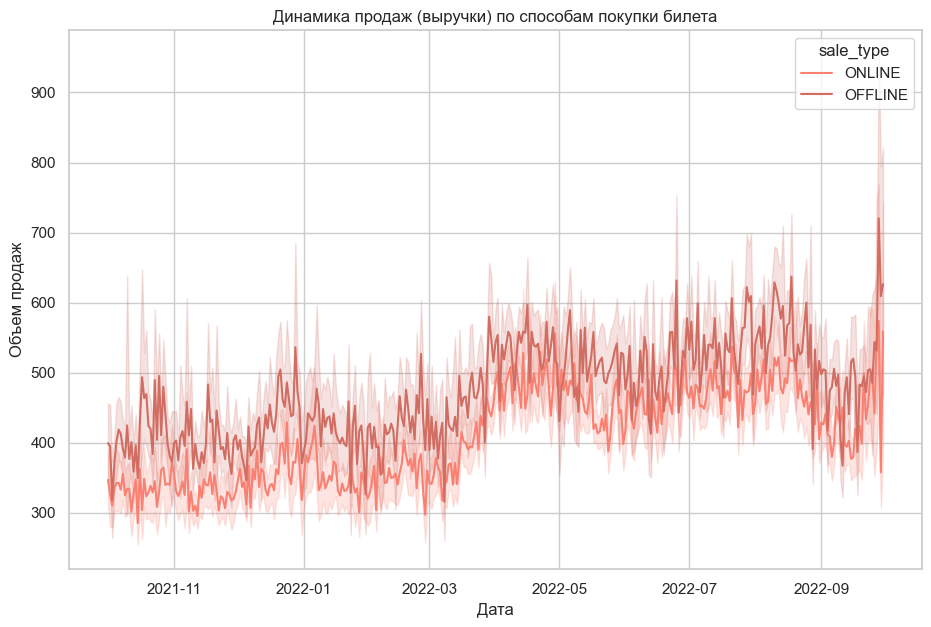

In [37]:
sns.lineplot(data=df, x='issue_date', y='revenue_amount', hue='sale_type').set(title='Динамика продаж (выручки) по способам покупки билета',
                                                                 xlabel='Дата', 
                                                                 ylabel='Объем продаж')
plt.show()

Уровень динамики по оффлайн покупкам оказался выше, чем по онлайн, несмотря на это, они обе имеют относительную положительную тенденцию, проседание в сентябре 2022 года скорее всего объясняется остутсвием полных данных. Видим, что верхний график в целом отражает такую же динамику, как на графике, не укрупненном по месяцам. 

In [56]:
plt.rcParams['figure.figsize'] = (8, 5)

In [57]:
#создадим сводную таблицу с данными о размере выручки по типам пассажиров
df_pax = df.pivot_table(index='pax_type', aggfunc='sum',values='revenue_amount').sort_values (by = 'revenue_amount', ascending=False).reset_index()
df_pax['share'] = round((df_pax['revenue_amount'] / df_pax['revenue_amount'].sum()) * 100, 2)
df_pax

,pax_type,revenue_amount,share
0,AD,20259210,93.78
1,CHD,1333430,6.17
2,INF,9730,0.05


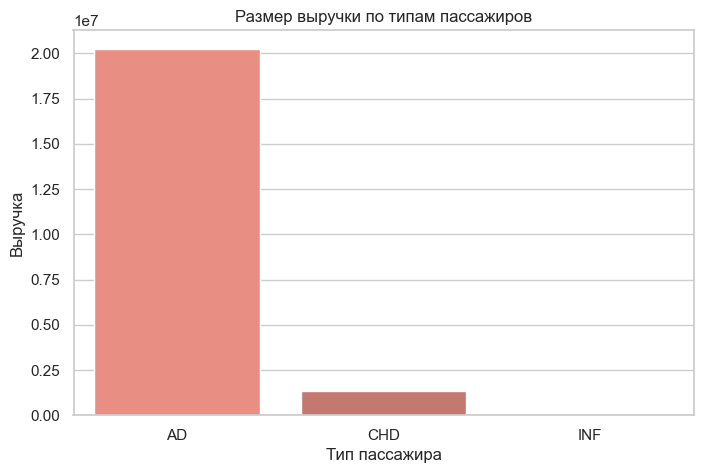

In [58]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_pax, y='revenue_amount', x='pax_type').set(title='Размер выручки по типам пассажиров',
                                                                               ylabel='Выручка',
                                                                               xlabel='Тип пассажира')
plt.show()

Как можно заметить, основную часть выручки авиакомпания получила за счет перелета взрослых пассажиров (AD), рассчитаем их долю выручки, чтобы более полно рассмотреть данный аспект. 

Таким образом,  покупка взрослыми пассажирами (AD) авиабилетов делает 93,78% от выручки авикомпании, детские билеты (CHD) приносят 6,17%, оставшаяся часть приходится на неидентифицированных пассажиров. 

In [59]:
#создадим сводную таблицу с данными о размере выручки по типам перелета
df_typefl = df.pivot_table(index='route_flight_type', aggfunc='sum',values='revenue_amount').sort_values (by = 'revenue_amount', ascending=False).reset_index()
df_typefl['share'] = round((df_typefl['revenue_amount'] / df_typefl['revenue_amount'].sum()) * 100, 2)
df_typefl

,route_flight_type,revenue_amount,share
0,ВВЛ,19610480,90.78
1,МВЛ,1991890,9.22


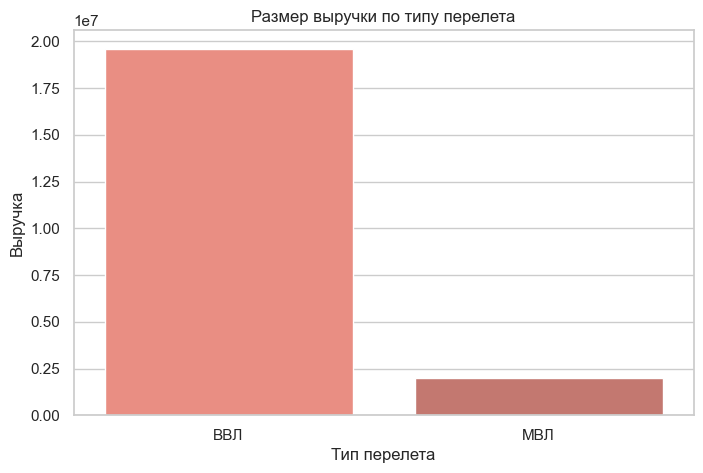

In [60]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_typefl, y='revenue_amount', x='route_flight_type').set(title='Размер выручки по типу перелета',
                                                                               ylabel='Выручка',
                                                                               xlabel='Тип перелета')
plt.show()

По итогам столбчатой диаграммы и свобдной таблицы с долями, можно сделать вывод о том, что основную часть выручки, а именно 90,78% приносят внутренние рейсы (ВВЛ), а меньшую часть - 9,22% - международные (МВЛ). 

In [61]:
#создадим сводную таблицу с данными о размере выручки по способам покупки
df_sale = df.pivot_table(index='sale_type', aggfunc='sum',values='revenue_amount').sort_values (by = 'revenue_amount', ascending=False).reset_index()
df_sale['share'] = round((df_sale['revenue_amount'] / df_sale['revenue_amount'].sum()) * 100, 2)
df_sale

,sale_type,revenue_amount,share
0,ONLINE,11285470,52.24
1,OFFLINE,10316900,47.76


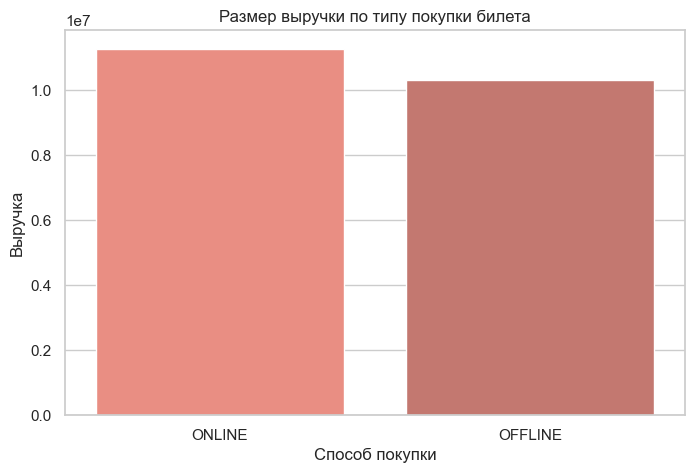

In [62]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_sale, y='revenue_amount', x='sale_type').set(title='Размер выручки по типу покупки билета',
                                                                               ylabel='Выручка',
                                                                               xlabel='Способ покупки')
plt.show()

Между объемами выручкек, приходящимися на два разных способа покупки билетов не такая значительная разница, их доли незначительно отличаются, но все же большая сумма покупок приходяится на онлайн покупки - 52,24%, оставшаяся часть - 47,76%, соответственно, на оффлайн покупки. 

In [63]:
#создадим сводную таблицу с данными о размере выручки по программе лояльности
df_ffq = df.pivot_table(index='ffp_flag', aggfunc='sum',values='revenue_amount').sort_values (by = 'revenue_amount', ascending=False).reset_index()
df_ffq['share'] = round((df_ffq['revenue_amount'] / df_ffq['revenue_amount'].sum()) * 100, 2)
df_ffq

,ffp_flag,revenue_amount,share
0,No,13379980,61.94
1,Yes,8222390,38.06


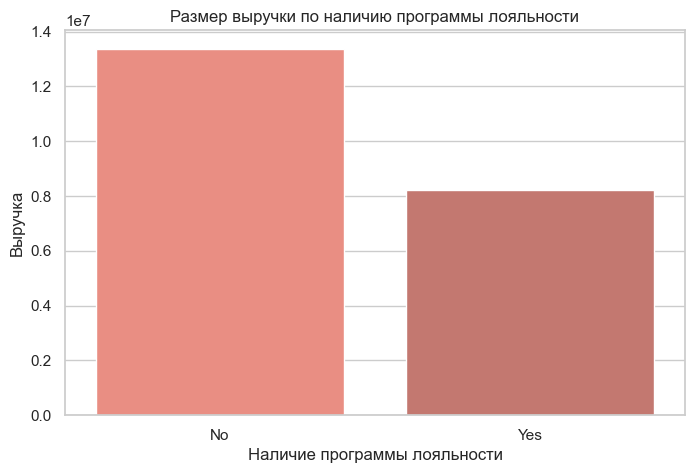

In [64]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_ffq, y='revenue_amount', x='ffp_flag').set(title='Размер выручки по наличию программы лояльности',
                                                                               ylabel='Выручка',
                                                                               xlabel='Наличие программы лояльности')
plt.show()

Таким образом, большую часть выручки (61,94%) авикомпания получила от пассажиров, которые не пользуются программой лояльности. 

### 3.2. Исследуйте выручку, примите решение об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.

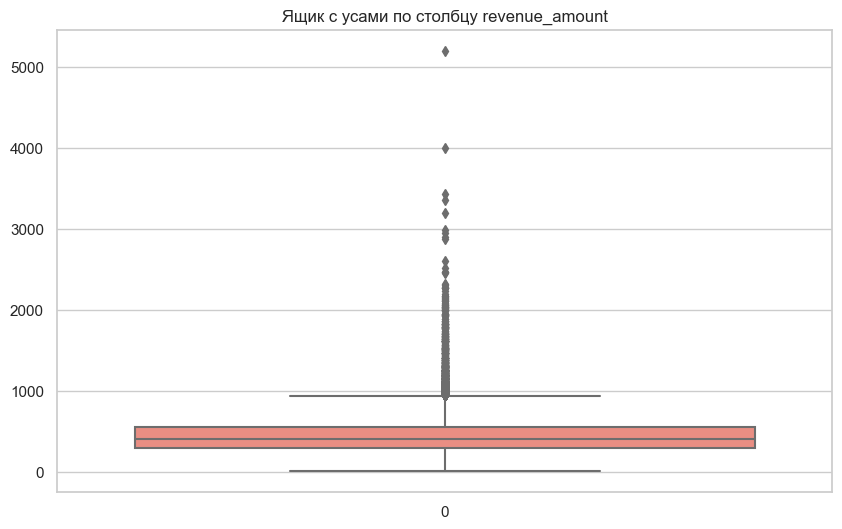

In [31]:
#построим ящик с усами для первичного ознкомления
sns.boxplot(data=df['revenue_amount']).set(title='Ящик с усами по столбцу revenue_amount')
plt.show()

Как видно из рисунка, в столбце с вырчукой у нас имееются нехарактерные значения - выбросы, находящиеся за усом ящика. 

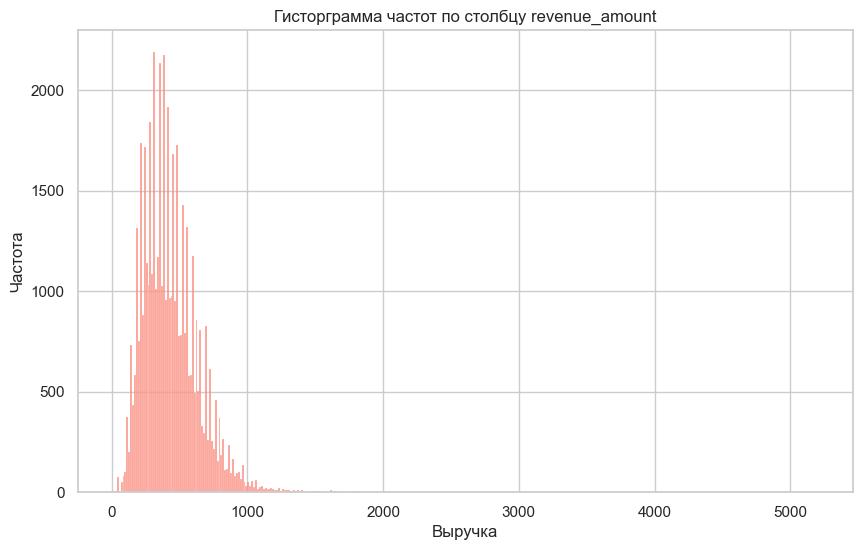

In [32]:
#построим гистограмму частот по выручке
sns.histplot(data=df['revenue_amount']).set(title='Гисторграмма частот по столбцу revenue_amount', ylabel='Частота',
                                                                               xlabel='Выручка')
plt.show()

На этой гистограмме также можно заметить нехарактерные единичные зачения после 1000 ед по оси выручки. 

In [33]:
#посмотрим основные характеристики этого слобца
df['revenue_amount'].describe()

count    49362.000000
mean       437.631579
std        214.611412
min         10.000000
25%        290.000000
50%        400.000000
75%        550.000000
max       5200.000000
Name: revenue_amount, dtype: float64

Значимое различие между средним значением и медианой также наталкивает на мысль о том, что в данных могут быть выбросы

In [34]:
#рассчитаем верхние и ниижние границы усов через квартили numpy
q75 = np.percentile(df['revenue_amount'], 75)
q25 = np.percentile(df['revenue_amount'], 25)
iqr = q75 - q25
ejection_h = q75 + iqr * 1.5
ejection_l = q25 - iqr * 1.5
print (ejection_h, ejection_l)

940.0 -100.0


In [35]:
#определим число выбросов - значений, которые находятся за пределами верхней и нижней границы. 
n_ejection = df['revenue_amount'][(df['revenue_amount'] > ejection_h) | (df['revenue_amount'] < ejection_l)].count()
print('Число выбросов равно:', n_ejection)
print('Доля выбросов в детасете:', round((n_ejection/df['revenue_amount'].count()*100), 2), '%')

Число выбросов равно: 987
Доля выбросов в детасете: 2.0 %


Не будем удалять эти записи из исходного датасета, создадим новый без них

In [36]:
#Отфильтруем датасет без выбросов 
good_df = df[(df['revenue_amount'] <= ejection_h) & (df['revenue_amount'] > ejection_l)]
good_df = good_df.reset_index(drop=True)
good_df.head()

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,No,OFFLINE,2021,12,2021-12-01
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,Yes,ONLINE,2021,11,2021-11-01
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,No,ONLINE,2021,12,2021-12-01
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE,2021,12,2021-12-01


In [71]:
#проверка
print (len(df) - len(good_df)) 

987


У нас есть 55 значений, равных верхней границе, в ходе исследования я пришла к выводу, что эти значения не ведут себя как выбросы, поэтому с целью минимизации потерь в данных мы их берем в новый детасет. 

In [72]:
df[df['revenue_amount'] == 940].count()

issue_date           55
flight_date_loc      55
pax_type             55
revenue_amount       55
orig_city_code       55
dest_city_code       55
route_flight_type    55
ffp_flag             55
sale_type            55
year                 55
month                55
month_year           55
dtype: int64

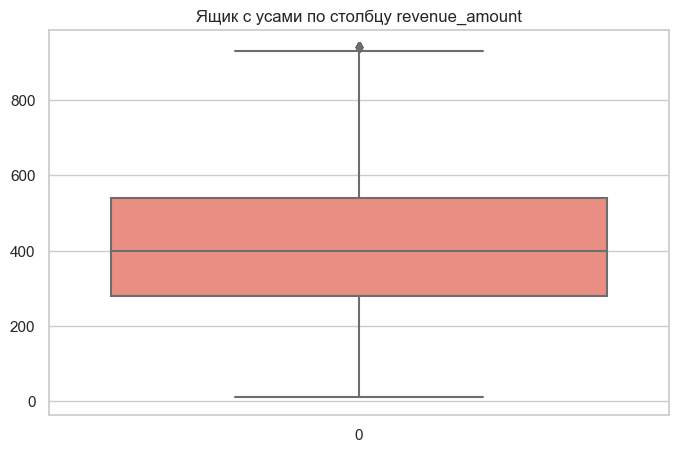

In [73]:
#построим ящик с усами для проверки ознкомления
sns.boxplot(data=good_df['revenue_amount']).set(title='Ящик с усами по столбцу revenue_amount')
plt.show()

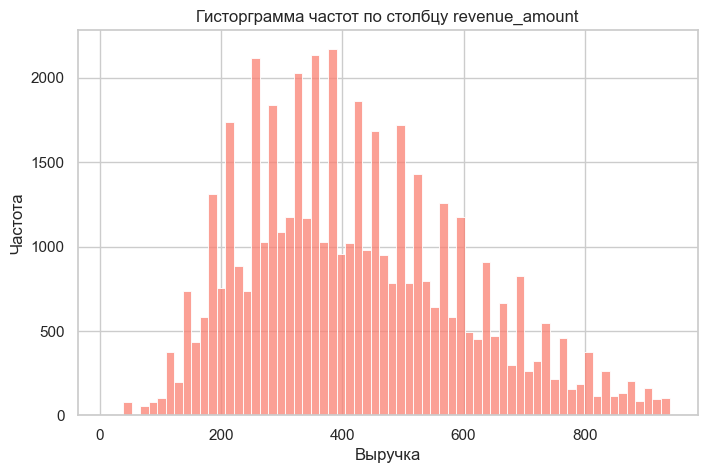

In [74]:
#построим гистограмму частот по выручке
sns.histplot(data=good_df['revenue_amount']).set(title='Гисторграмма частот по столбцу revenue_amount', ylabel='Частота',
                                                                               xlabel='Выручка')
plt.show()

Как можно заметить, от выбросов мы избавились и данные распределяются куда равномернее чем было раньше. 

### 3.3 Исследуйте сезонность продаж. Дополнительно проверьте гипотезу о том, что выручка от продаж осенью и зимой отличается. Исследуйте выручку и число продаж по месяцам, проверьте корреляцию. 

In [75]:
#посмотрим уникальыне значения в столбце Month
good_df['month'].unique()

array([12, 11,  1, 10,  6,  7,  8,  4,  5,  2,  3,  9], dtype=int64)

In [76]:
#изменим тип данных столбца Month на строчный
good_df['month'] = good_df['month'].astype('str')

In [77]:
#создадим словарь с месяцами-ключами и сезонами
season_dict = {'1':'Зима',
          '2':'Зима',
          '12':'Зима',
          '3':'Весна',
          '4':'Весна',
          '5':'Весна',
          '6':'Лето',
          '7':'Лето',
          '8':'Лето',
          '9':'Осень',
          '10':'Осень',
          '11':'Осень'}

In [78]:
#применим словарь к детасету
good_df['season'] = good_df['month'].map(season_dict)
good_df

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,season
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01,Зима
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,No,OFFLINE,2021,12,2021-12-01,Зима
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,Yes,ONLINE,2021,11,2021-11-01,Осень
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,No,ONLINE,2021,12,2021-12-01,Зима
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE,2021,12,2021-12-01,Зима
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48370,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,No,ONLINE,2022,6,2022-06-01,Лето
48371,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,Лето
48372,2022-06-26,2022-06-29,AD,230,MOW,KZN,ВВЛ,Yes,ONLINE,2022,6,2022-06-01,Лето
48373,2022-06-26,2022-06-28,AD,270,KZN,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,Лето


In [79]:
#создадим сводную таблицу с данными о размере выручки по сезонам
df_season = good_df.pivot_table(index='season', aggfunc='sum',values='revenue_amount').sort_values (by = 'revenue_amount', ascending=False).reset_index()
df_season['share'] = round((df_season['revenue_amount'] / df_season['revenue_amount'].sum()) * 100, 2)
df_season

,season,revenue_amount,share
0,Лето,6207480,30.41
1,Весна,5345840,26.19
2,Осень,4590790,22.49
3,Зима,4267290,20.91


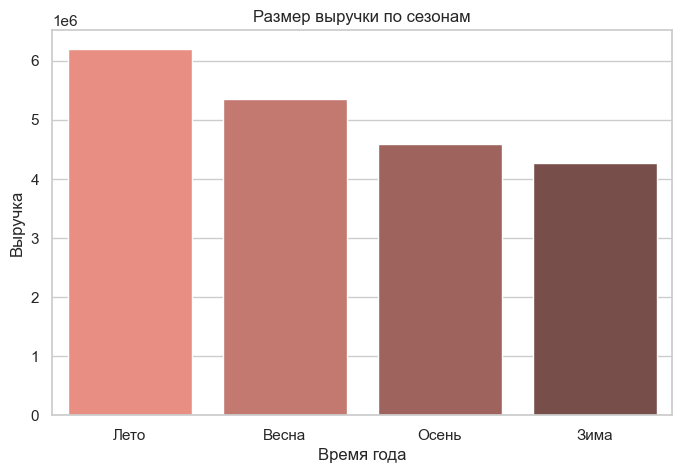

In [80]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_season, y='revenue_amount', x='season').set(title='Размер выручки по сезонам',
                                                                               ylabel='Выручка',
                                                                               xlabel='Время года')
plt.show()

Как можно заметить, наибольшую выручку авикомпания получила от продажи билетов в летний сезон, наименьшую - в зимний. 

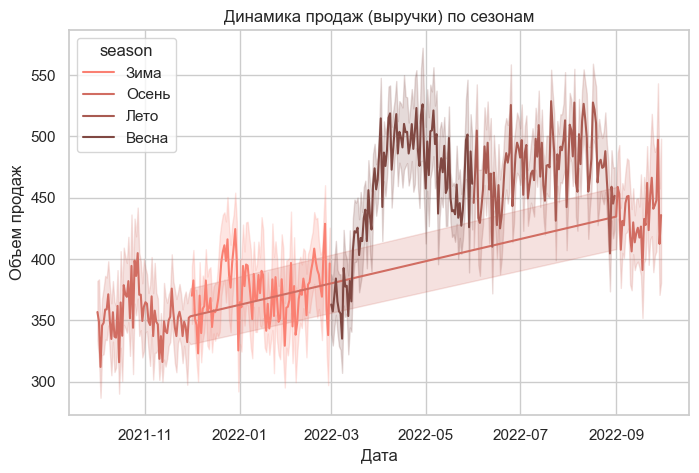

In [81]:
#построим линейный график динамики выручки по временам года 
sns.lineplot(data=good_df, x='issue_date', y='revenue_amount', hue='season').set(title='Динамика продаж (выручки) по сезонам',
                                                                 xlabel='Дата', 
                                                                 ylabel='Объем продаж')
plt.show()

Мы окрасили самый первый график с динамикой в сезоны. Видно, что весной произошел резкий рост выручки компании от продажи билетов, который, возможно связан с предстоящим сезоном отпусков, летом в целом динамика снизила темпы роста, но смогла сохранить средний уровень роста.

Проверим следующие гипотезы: <br>
H0: средние выручки от продаж зимой и осенью равны друг другу <br>
H1: средние выручки от продаж зимой и осенью не равны друг другу

In [82]:
good_df['revenue_amount'].describe()

count    48375.000000
mean       421.941085
std        178.547873
min         10.000000
25%        280.000000
50%        400.000000
75%        540.000000
max        940.000000
Name: revenue_amount, dtype: float64

Различия между средним значением и медианой не такое большое, как было раньше, что может подсказывать на возможную нормальность распределения, но этого недостаточно, поэтому проверим нормальность распределения и другими более точными способами перед тем как использовать t-тест на проверку верхних гипотез. 

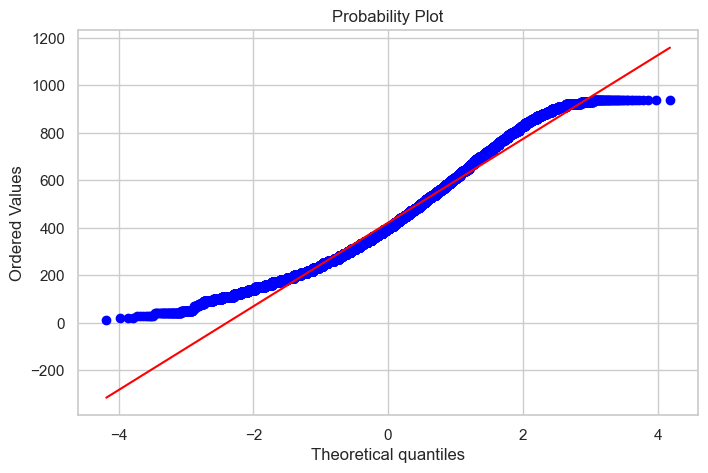

In [83]:
#построим Q-Q график
st.probplot(good_df['revenue_amount'], dist='norm', plot=plt)
plt.show()

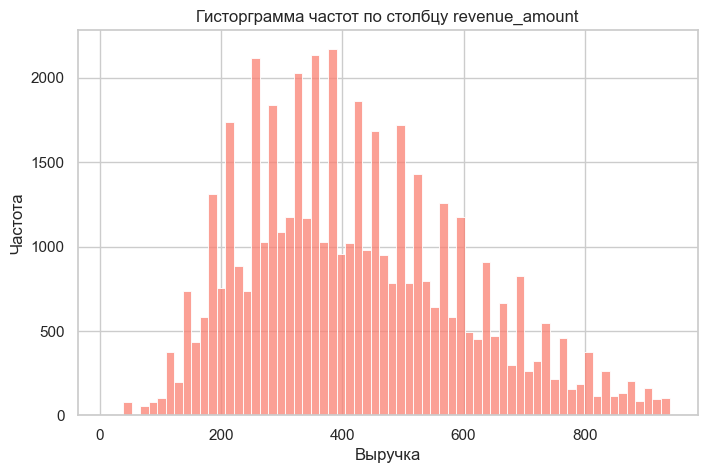

In [84]:
#построим гистограмму частот 
sns.histplot(data=good_df['revenue_amount']).set(title='Гисторграмма частот по столбцу revenue_amount', ylabel='Частота',
                                                                               xlabel='Выручка')
plt.show()

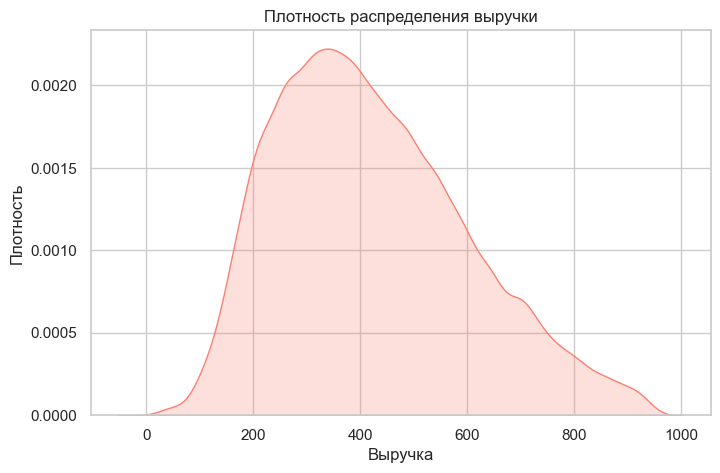

In [85]:
sns.kdeplot(good_df['revenue_amount'], fill=True).set(title='Плотность распределения выручки',
                                                                 xlabel='Выручка', 
                                                                 ylabel='Плотность')
plt.show()

На основании плотности распределения и QQ-plotа можно сделать вывод, что распределение данных о выручке не имеет нормальный вид. Нам необходимо использовать в таком случае непараметрический тест Уилкоксона-Манна-Уитни. 

Проверим следующие гипотезы: <br>
H0: средние выручки от продаж зимой и осенью равны друг другу <br>
H1: средние выручки от продаж зимой и осенью не равны друг другу

In [86]:
#создадим два списка с данными по продажам за осень и зиму
winter = list(good_df[good_df['season'] == 'Зима']['revenue_amount'])
autmn = list(good_df[good_df['season'] == 'Осень']['revenue_amount'])

In [87]:
#посчитаем сраднее значение выручки за зиму
np.mean(winter)

372.49388966480444

In [88]:
#посчитаем сраднее значение выручки за осень
np.mean(autmn)

374.9726374254676

In [89]:
#проведем непараметрический тест Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(winter, autmn) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 0.4549933504837227
Нулевая гипотеза не отвергается


In [90]:
#проводим t-test
alpha = 0.05
results = st.ttest_ind(winter, autmn, equal_var=False) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 0.26166345149466574
Нулевая гипотеза не отвергается


Таким образом, несмотря на ненормальность распределения результаты t-теста и непараметрического теста Уилкоксона-Манна-Уитни оказались одинаковыми, значит, разброс данных не оказал сильного воздействия на корректность теста Стьюдента. Таким образом, с вероятностью 0,95 средние выручки в осенний и зимний периоды равны друг другу. 

In [91]:
#создадим сводную таблицу с данными о размере выручки и количестве продаж по месяцам
df_month = good_df.pivot_table(index='month', aggfunc=['sum', 'count'],values='revenue_amount').reset_index()
df_month.columns=['month','sum_revenue', 'count_sales']
df_month['month'] = df_month['month'].astype('int')
df_month

,month,sum_revenue,count_sales
0,1,1304090,3552
1,10,1280870,3579
2,11,1766940,5109
3,12,1666010,4490
4,2,1297190,3414
5,3,1759960,4275
6,4,1934200,3887
7,5,1651680,3563
8,6,1538600,3287
9,7,2447960,5093


Так как распределение у нас имеет ненормальный вид, нам нужно использовать коэффициент Кендала для расчета корреляции, кроме того, он устойчив к выбросам.  

In [92]:
#исследуем зависимость между выручкой и месяцем покупки билета с помощью корреляции Кендала
corr_1 = kendalltau(df_month['sum_revenue'], df_month['month'])
print('Коэффициент корреляции между выручкой и месяцем покупки билета равен', corr_1[0])

Коэффициент корреляции между выручкой и месяцем покупки билета равен 0.1212121212121212


Таким образом, по шкале Чеддока связь между фактором (месяц покупки) и результатом (выручка) прямая и очень слабая. 

In [93]:
#исследуем зависимость между объмом продаж и месяцем покупки билета с помощью корреляции Кендала
corr_2 = kendalltau(df_month['count_sales'], df_month['month'])
print('Коэффициент корреляции между объмом продаж и месяцем покупки билета равен', corr_2[0])

Коэффициент корреляции между объмом продаж и месяцем покупки билета равен 0.3333333333333333


Таким образом, по шкале Чеддока связь между фактором (месяц покупки) и результатом (объем продаж) прямая и слабая.

In [94]:
#отсортируем таблицу
df_month = df_month.sort_values(by = 'month', ascending=True)
df_month

,month,sum_revenue,count_sales
0,1,1304090,3552
4,2,1297190,3414
5,3,1759960,4275
6,4,1934200,3887
7,5,1651680,3563
8,6,1538600,3287
9,7,2447960,5093
10,8,2220920,4571
11,9,1542980,3555
1,10,1280870,3579


In [95]:
#создадим словарь с месяцами-ключами и цифрами
df_month['month'] = df_month['month'].astype('str')
months_dict = {'1':'Январь',
          '2':'Февраль',
          '12':'Декабрь',
          '3':'Март',
          '4':'Апрель',
          '5':'Май',
          '6':'Июнь',
          '7':'Июль',
          '8':'Август',
          '9':'Сентябрь',
          '10':'Октябрь',
          '11':'Ноябрь'}
#применим словарь к сводной таблице
df_month['month'] = df_month['month'].map(months_dict)
df_month

,month,sum_revenue,count_sales
0,Январь,1304090,3552
4,Февраль,1297190,3414
5,Март,1759960,4275
6,Апрель,1934200,3887
7,Май,1651680,3563
8,Июнь,1538600,3287
9,Июль,2447960,5093
10,Август,2220920,4571
11,Сентябрь,1542980,3555
1,Октябрь,1280870,3579


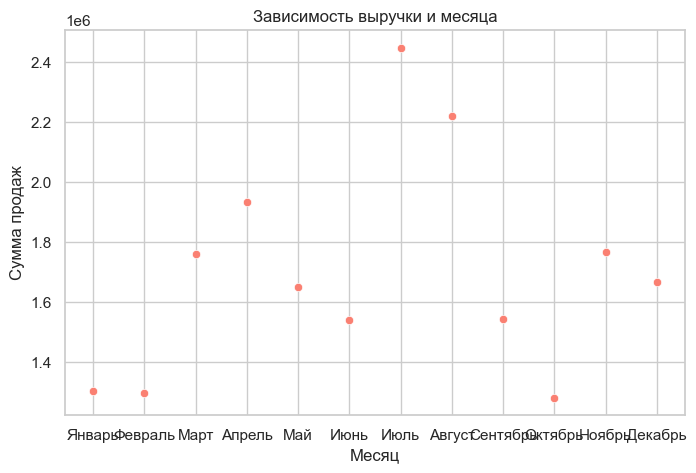

In [96]:
#построим пузырьковую диаграмму для пары месяц-объем выручки
sns.scatterplot(data=df_month, x='month', y='sum_revenue').set(title='Зависимость выручки и месяца',
                                                                 xlabel='Месяц', 
                                                                 ylabel='Сумма продаж')
plt.show()

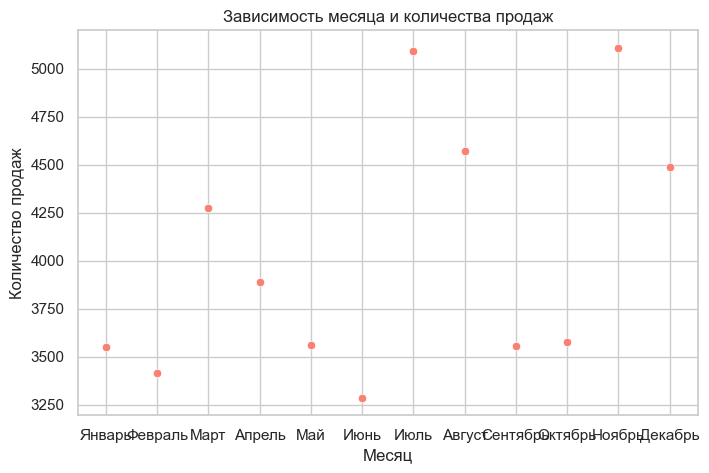

In [97]:
#построим пузырьковую диаграмму для пары месяц-количество продаж 
sns.scatterplot(data=df_month, x='month', y='count_sales').set(title='Зависимость месяца и количества продаж',
                                                                 xlabel='Месяц', 
                                                                 ylabel='Количество продаж')
plt.show()

Эти две диаграммы подтвержают слабую связь смежду выручкой и этими двумя факторами, так как точки разбросаны в хаотичном порядке.

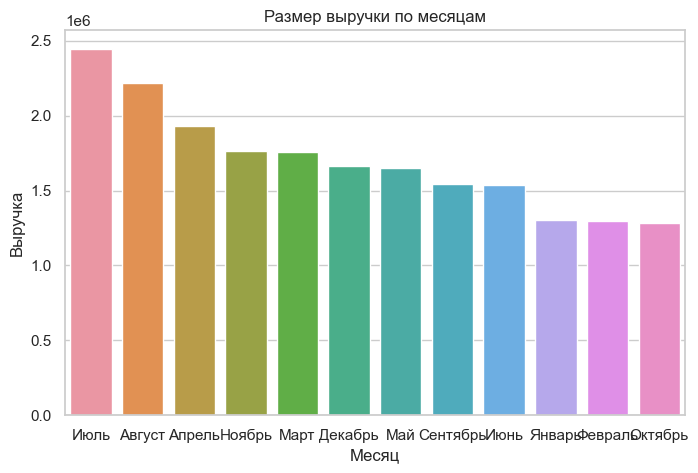

In [98]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_month.sort_values(by = 'sum_revenue', ascending=False), y='sum_revenue', x='month').set(title='Размер выручки по месяцам',
                                                                               ylabel='Выручка',
                                                                               xlabel='Месяц')
plt.show()

Ранее мы поняли, что наибольшую выручку компания получила в летний период, теперь же мы знаем, что это произошло в июле, также много компания заработала в августе. Меньше всего удалось заработать в январе, феврале и октябре. 

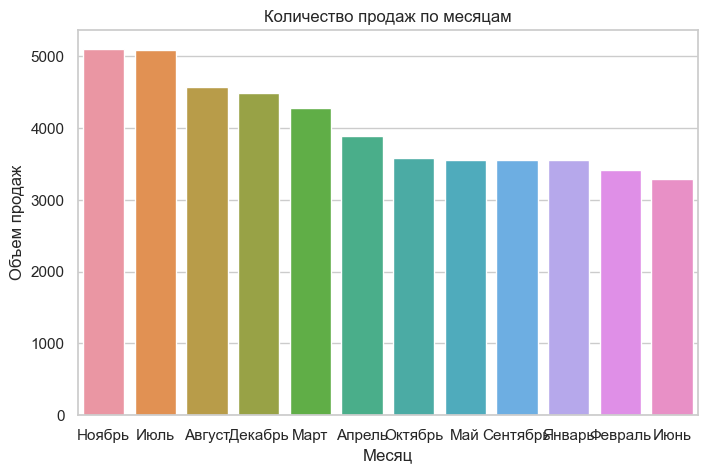

In [99]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_month.sort_values(by = 'count_sales', ascending=False), y='count_sales', x='month').set(title='Количество продаж по месяцам',
                                                                               ylabel='Объем продаж',
                                                                               xlabel='Месяц')
plt.show()

Однако, больше всего было продано билетов в октябре, возможно по раннему бронированию и с невысокой стоимостью, а также в июле, где как раз имело место позднее бронирование с высокими сезонными ценами. 

### 3.4. Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверьте гипотезу о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительно разбейте клиентов минимум на три группы.

In [35]:
#добавим столбец с разницей дат между покупкой и белета и датой поездки в днях
good_df['difference_date'] = good_df['flight_date_loc'] - good_df['issue_date']
good_df

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,difference_date
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01,35 days
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,No,OFFLINE,2021,12,2021-12-01,3 days
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,Yes,ONLINE,2021,11,2021-11-01,37 days
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,No,ONLINE,2021,12,2021-12-01,28 days
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE,2021,12,2021-12-01,35 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48370,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,No,ONLINE,2022,6,2022-06-01,11 days
48371,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,14 days
48372,2022-06-26,2022-06-29,AD,230,MOW,KZN,ВВЛ,Yes,ONLINE,2022,6,2022-06-01,3 days
48373,2022-06-26,2022-06-28,AD,270,KZN,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,2 days


In [36]:
#изменим тип столбца на строки, чтобы убрать слово days 
good_df['difference_date'] = good_df['difference_date'].astype('str')
list_1 =[]
for i in good_df['difference_date']:
    i = i[:-5]
    list_1.append(i)
good_df['difference_date'] = list_1

In [37]:
#изменим тип данных столбца - вернем обратно исходный
good_df['difference_date'] = good_df['difference_date'].astype('int')
good_df

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,difference_date
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01,35
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,No,OFFLINE,2021,12,2021-12-01,3
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,Yes,ONLINE,2021,11,2021-11-01,37
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,No,ONLINE,2021,12,2021-12-01,28
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE,2021,12,2021-12-01,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48370,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,No,ONLINE,2022,6,2022-06-01,11
48371,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,14
48372,2022-06-26,2022-06-29,AD,230,MOW,KZN,ВВЛ,Yes,ONLINE,2022,6,2022-06-01,3
48373,2022-06-26,2022-06-28,AD,270,KZN,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,2


Разобьем клиентов на три группы в зависимости от срока бронирования: раннее бронирование (за 2 месяца и больше), умеренное бронирование (за 1 месяц до поездки, но позднее, чем за 2 месяца), позднее бронирование (позднее, чем за 1 месяц). 

In [38]:
#позднее бронирование - создадим новый детасет
group_1 = good_df[good_df['difference_date'] < 30]
group_1

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,difference_date
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,No,OFFLINE,2021,12,2021-12-01,3
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,No,ONLINE,2021,12,2021-12-01,28
12,2021-12-08,2022-01-03,AD,210,KZN,MOW,ВВЛ,No,ONLINE,2021,12,2021-12-01,26
18,2021-12-15,2022-01-04,AD,570,OVB,LED,ВВЛ,No,OFFLINE,2021,12,2021-12-01,20
20,2022-01-13,2022-01-17,AD,570,OVB,EVN,МВЛ,No,OFFLINE,2022,1,2022-01-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48370,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,No,ONLINE,2022,6,2022-06-01,11
48371,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,14
48372,2022-06-26,2022-06-29,AD,230,MOW,KZN,ВВЛ,Yes,ONLINE,2022,6,2022-06-01,3
48373,2022-06-26,2022-06-28,AD,270,KZN,MOW,ВВЛ,No,OFFLINE,2022,6,2022-06-01,2


In [39]:
#умеренное бронирование - создадим новый детасет
group_2 = good_df[(30 <= good_df['difference_date']) & (good_df['difference_date'] < 60)]
group_2

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,difference_date
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01,35
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,Yes,ONLINE,2021,11,2021-11-01,37
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE,2021,12,2021-12-01,35
5,2021-11-29,2022-01-14,AD,250,MOW,DUS,МВЛ,No,ONLINE,2021,11,2021-11-01,46
6,2021-12-03,2022-01-06,AD,200,MOW,PEE,ВВЛ,Yes,ONLINE,2021,12,2021-12-01,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48266,2022-04-10,2022-05-15,AD,550,RGK,MOW,ВВЛ,Yes,ONLINE,2022,4,2022-04-01,35
48268,2022-04-07,2022-05-16,AD,260,UFA,MOW,ВВЛ,Yes,ONLINE,2022,4,2022-04-01,39
48269,2022-04-25,2022-05-25,AD,390,OVB,FRU,МВЛ,Yes,ONLINE,2022,4,2022-04-01,30
48270,2022-04-01,2022-05-17,AD,530,IKT,MOW,ВВЛ,No,ONLINE,2022,4,2022-04-01,46


In [40]:
#раннее бронирование - создадим новый детасет
group_3 = good_df[good_df['difference_date'] >= 60]
group_3

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,difference_date
30,2021-12-01,2022-01-30,AD,200,EGO,MOW,ВВЛ,No,OFFLINE,2021,12,2021-12-01,60
103,2021-12-01,2022-01-30,AD,540,OVB,PKC,ВВЛ,No,ONLINE,2021,12,2021-12-01,60
138,2021-11-29,2022-01-31,AD,390,OVB,IKT,ВВЛ,No,ONLINE,2021,11,2021-11-01,63
552,2022-06-02,2022-08-15,AD,350,MOW,UFA,ВВЛ,No,OFFLINE,2022,6,2022-06-01,74
557,2022-04-17,2022-08-18,AD,390,OVB,NUX,ВВЛ,No,OFFLINE,2022,4,2022-04-01,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48010,2021-10-16,2021-12-19,AD,260,KJA,MOW,ВВЛ,Yes,ONLINE,2021,10,2021-10-01,64
48044,2022-04-01,2022-05-31,AD,420,VVO,IKT,ВВЛ,Yes,ONLINE,2022,4,2022-04-01,60
48170,2022-03-31,2022-05-31,CHD,300,UUS,VVO,ВВЛ,No,ONLINE,2022,3,2022-03-01,61
48178,2022-03-31,2022-05-31,AD,580,PKC,OVB,ВВЛ,No,OFFLINE,2022,3,2022-03-01,61


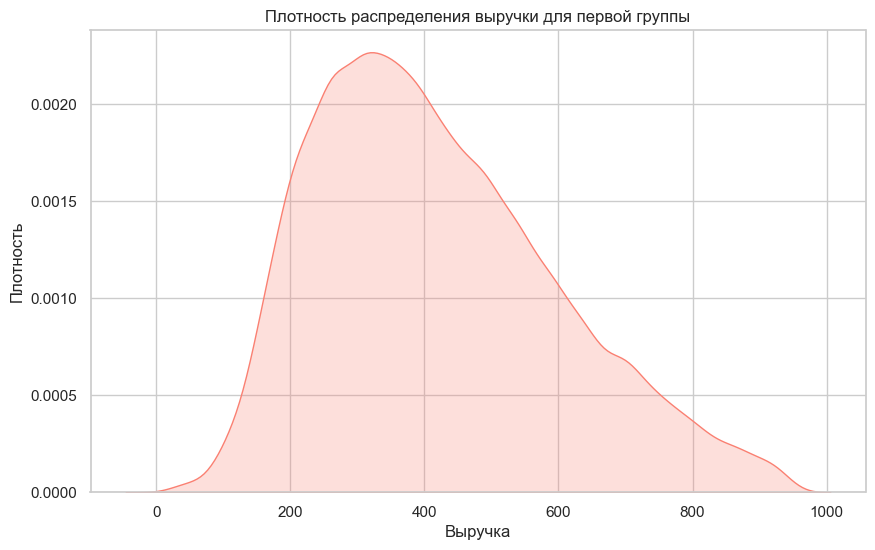

In [42]:
sns.kdeplot(group_1['revenue_amount'], fill=True).set(title='Плотность распределения выручки для первой группы',
                                                                 xlabel='Выручка', 
                                                                 ylabel='Плотность')
plt.show()

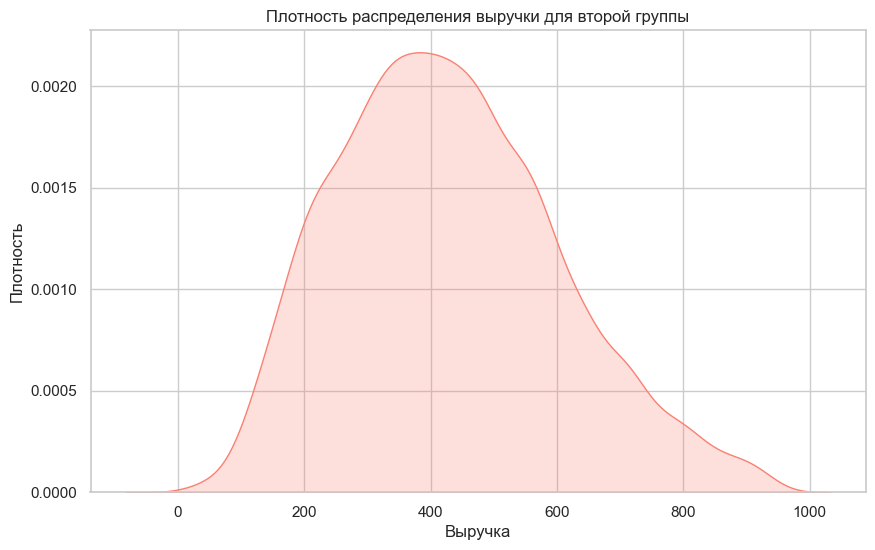

In [43]:
sns.kdeplot(group_2['revenue_amount'], fill=True).set(title='Плотность распределения выручки для второй группы',
                                                                 xlabel='Выручка', 
                                                                 ylabel='Плотность')
plt.show()

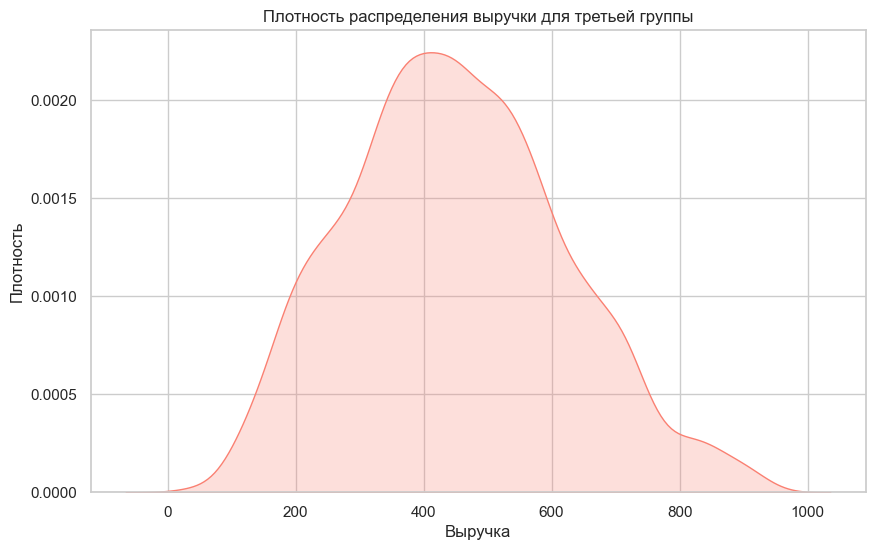

In [44]:
sns.kdeplot(group_3['revenue_amount'], fill=True).set(title='Плотность распределения выручки для третьей группы',
                                                                 xlabel='Выручка', 
                                                                 ylabel='Плотность')
plt.show()

Как видно из графиков, распределение данных в этих группах ненормальное, значит для проверки гипотез надо использовать тест Уилкоксона-Манна-Уитни

Посчитаем среднюю выручку от каждой группы клиентов:

In [106]:
#позднее бронирование
mean_group_1 = group_1['revenue_amount'].mean()
mean_group_1

417.84844843798976

In [107]:
#умеренное бронирование
mean_group_2 = group_2['revenue_amount'].mean()
mean_group_2

428.04013146514444

In [108]:
#раннее бронирование
mean_group_3 = group_3['revenue_amount'].mean()
mean_group_3

450.1136890951276

Проверим следующие гипотезы: <br>
H0: средние выручки от продаж раннего и позднего бронирования равны друг другу <br>
H1: средние выручки от продаж раннего и позднего бронирования не равны друг другу

In [109]:
#создадим два списка с данными по продажам раннего и позднего бронирования
early = list(group_3['revenue_amount'])
later = list(group_1['revenue_amount'])

In [110]:
#проведем непараметрический тест Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(early, later) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 5.0148518981424674e-42
Отклоянем нулевую гипотезу


In [111]:
#проводим t-test ради интереса
alpha = 0.05
results = st.ttest_ind(early, later, equal_var=False) 

print('p-value:', results.pvalue)

# формулируем результаты
if results.pvalue < alpha:
    print('Отклоянем нулевую гипотезу')
else:
    print('Нулевая гипотеза не отвергается')

p-value: 1.1171375415213875e-31
Отклоянем нулевую гипотезу


Таким образом, средние выручки от продаж раннего и позднего бронирования не равны друг другу с вероятностью 0,95.

### 3 .5. Определите топ-10 популярных направлений перелета (город-город) отдельно для ВМЛ и МВЛ. Изучите выручку для этих направлений. Для этого добавьте в датасет сведения о городах, используя данные из датасета: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

In [37]:
#загрузим датасет
df_1 = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', sep=',', names = ['index', 'airport_name', 'location', 'country', 'iata_code', 'icao_code', 'latitude', 'longitude', 'altitude', 'timezone', 'dst', 'timezone_region', 'type', 'source'])
df_1

,index,airport_name,location,country,iata_code,icao_code,latitude,longitude,altitude,timezone,dst,timezone_region,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


In [38]:
#создадим таблицу из прошлого датасета, вытащив нужные нам столбцы
df_2 = df_1[['airport_name','location', 'iata_code', 'latitude', 'longitude']]
df_2

,airport_name,location,iata_code,latitude,longitude
0,Goroka Airport,Goroka,GKA,-6.081690,145.391998
1,Madang Airport,Madang,MAG,-5.207080,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,HGU,-5.826790,144.296005
3,Nadzab Airport,Nadzab,LAE,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,Port Moresby,POM,-9.443380,147.220001
...,...,...,...,...,...
7693,Rogachyovo Air Base,Belaya,\N,71.616699,52.478298
7694,Ulan-Ude East Airport,Ulan Ude,\N,51.849998,107.737999
7695,Krechevitsy Air Base,Novgorod,\N,58.625000,31.385000
7696,Desierto de Atacama Airport,Copiapo,CPO,-27.261200,-70.779198


In [39]:
#изучим пропуски
df_2[df_2['location'].isna()]

,airport_name,location,iata_code,latitude,longitude
7031,Minsk Mazowiecki Military Air Base,NaN,\N,52.195499,21.655899
7032,Powidz Military Air Base,NaN,\N,52.379398,17.853901
7137,King Salman Abdulaziz Airport,NaN,DWD,24.449900,44.121201
7138,King Khaled Air Base,NaN,KMX,18.297300,42.803501
7158,Asahikawa Airfield,NaN,\N,43.794734,142.365432
7160,Utsunomiya Airport,NaN,\N,36.514500,139.871010
7161,Jungwon Air Base/Chungju Airport,NaN,\N,37.030240,127.886353
7164,Bislig Airport,NaN,BPH,8.195950,126.321999
7165,Mati National Airport,NaN,MXI,6.949091,126.273680
7184,Metropolitano Airport,NaN,\N,10.133169,-66.787827


In [40]:
# презаписываем датасет, удаляя пропуски в кодах, так как нам они не помогут
df_2 = df_2.query('iata_code != "\\\\N"').reset_index(drop=True)
df_2

,airport_name,location,iata_code,latitude,longitude
0,Goroka Airport,Goroka,GKA,-6.081690,145.391998
1,Madang Airport,Madang,MAG,-5.207080,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,HGU,-5.826790,144.296005
3,Nadzab Airport,Nadzab,LAE,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,Port Moresby,POM,-9.443380,147.220001
...,...,...,...,...,...
6067,Bilogai-Sugapa Airport,Sugapa-Papua Island,UGU,-3.739560,137.031998
6068,Ramon Airport,Eilat,ETM,29.723694,35.011416
6069,Rustaq Airport,Al Masna'ah,MNH,23.640556,57.487500
6070,Laguindingan Airport,Cagayan de Oro City,CGY,8.612203,124.456496


In [41]:
#сверим есть ли среди кодов с пропусками location что-то в исходном датасете
list_1 = list(df_2[df_2['location'].isna()]['iata_code'].unique())
list_2 = list(good_df['orig_city_code'].unique())
list_3 = list(good_df['dest_city_code'].unique())
list_4 = list(df_2['iata_code'].unique())
c = []
for i in list_1:
    for j in list_3:
        if i == j:
            c.append(i)
            break
print(c)

[]


In [42]:
for i in list_1:
    for j in list_2:
        if i == j:
            c.append(i)
            break
print(c)

[]


Значит, эти пропуски можно не заполнять, так как таких кодов нет в исходном датасете. Теперь проверим полон ли наш новый датасет кодами (df_2). Или же там нет чего-то, что естm в good_df?

In [43]:
#теперь найдем те, что есть в good_df, но их нет в df_2
set(list_3) - set(list_4)

{'BAK',
 'BER',
 'GRV',
 'LON',
 'MIL',
 'MOW',
 'NQZ',
 'PAR',
 'ROM',
 'SEL',
 'TOX',
 'TYO'}

In [44]:
set(list_2) - set(list_4)

{'BAK',
 'BER',
 'GRV',
 'LON',
 'MIL',
 'MOW',
 'NQZ',
 'OHH',
 'PAR',
 'ROM',
 'SEL',
 'TOX',
 'TYO'}

In [45]:
#создадим с ними сводную таблицу
dff = pd.DataFrame({'location':['Baku','Berlin','Grozny','London','Milan','Astana','Moscow','Paris', 'Rome','Seoul','Tobolsk','Tokyo', 'Okha'],
    'iata_code': ['BAK', 'BER', 'GRV', 'LON', 'MIL', 'NQZ', 'MOW', 'PAR', 'ROM', 'SEL', 'TOX', 'TYO', 'OHH']
})
dff

,location,iata_code
0,Baku,BAK
1,Berlin,BER
2,Grozny,GRV
3,London,LON
4,Milan,MIL
5,Astana,NQZ
6,Moscow,MOW
7,Paris,PAR
8,Rome,ROM
9,Seoul,SEL


In [46]:
#добавим их в наш детасет 
df_2 = pd.concat([dff, df_2], ignore_index = True)
df_2

,location,iata_code,airport_name,latitude,longitude
0,Baku,BAK,NaN,NaN,NaN
1,Berlin,BER,NaN,NaN,NaN
2,Grozny,GRV,NaN,NaN,NaN
3,London,LON,NaN,NaN,NaN
4,Milan,MIL,NaN,NaN,NaN
...,...,...,...,...,...
6080,Sugapa-Papua Island,UGU,Bilogai-Sugapa Airport,-3.739560,137.031998
6081,Eilat,ETM,Ramon Airport,29.723694,35.011416
6082,Al Masna'ah,MNH,Rustaq Airport,23.640556,57.487500
6083,Cagayan de Oro City,CGY,Laguindingan Airport,8.612203,124.456496


In [47]:
df_2[df_2['location'] == 'Moscow']

,location,iata_code,airport_name,latitude,longitude
6,Moscow,MOW,NaN,NaN,NaN
2292,Moscow,SVO,Sheremetyevo International Airport,55.972599,37.414600
2295,Moscow,VKO,Vnukovo International Airport,55.591499,37.261501
3204,Moscow,DME,Domodedovo International Airport,55.408798,37.906300
3470,Moscow,BKA,Bykovo Airport,55.617199,38.060001
5287,Moscow,OSF,Ostafyevo International Airport,55.511667,37.507222


In [48]:
#заменим SVO на MOW
df_2['iata_code'] = df_2['iata_code'].replace({'SVO':'MOW'}, regex=True)

In [49]:
#удалим коды этих аэропортов
df_2 = df_2.drop(labels = [6, 2295, 3204, 3470, 5287], axis = 0)
df_2[df_2['location'] == 'Moscow']

,location,iata_code,airport_name,latitude,longitude
2292,Moscow,MOW,Sheremetyevo International Airport,55.972599,37.4146


In [50]:
#удалим строки с пропусками в location, так как таких начений нет в исходном датасете и мы ничего не потеряем 
df_2 = df_2.dropna(subset=['location'])
df_2

,location,iata_code,airport_name,latitude,longitude
0,Baku,BAK,NaN,NaN,NaN
1,Berlin,BER,NaN,NaN,NaN
2,Grozny,GRV,NaN,NaN,NaN
3,London,LON,NaN,NaN,NaN
4,Milan,MIL,NaN,NaN,NaN
...,...,...,...,...,...
6080,Sugapa-Papua Island,UGU,Bilogai-Sugapa Airport,-3.739560,137.031998
6081,Eilat,ETM,Ramon Airport,29.723694,35.011416
6082,Al Masna'ah,MNH,Rustaq Airport,23.640556,57.487500
6083,Cagayan de Oro City,CGY,Laguindingan Airport,8.612203,124.456496


In [51]:
df_2.isna().sum()

location         0
iata_code        0
airport_name    12
latitude        12
longitude       12
dtype: int64

In [52]:
df_2 = df_2[['location', 'iata_code', 'latitude', 'longitude']]
df_3 = df_2[df_2['location'] != 0]

In [53]:
#посчитаем сумму дубликатов 
df_3.duplicated().sum()

0

In [54]:
#переименуем столбцы
df_3.columns = ['location_departure', 'orig_city_code','lat_dep', 'lon_dep']

In [55]:
#соединим нам исходный датасет с только что загруженным по кодам грода отправления
good_df_1 = good_df.merge(df_3, on='orig_city_code')
good_df_1

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,location_departure,lat_dep,lon_dep
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01,Moscow,55.972599,37.414600
1,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,Yes,OFFLINE,2021,12,2021-12-01,Moscow,55.972599,37.414600
2,2021-11-29,2022-01-14,AD,250,MOW,DUS,МВЛ,No,ONLINE,2021,11,2021-11-01,Moscow,55.972599,37.414600
3,2021-12-03,2022-01-06,AD,200,MOW,PEE,ВВЛ,Yes,ONLINE,2021,12,2021-12-01,Moscow,55.972599,37.414600
4,2021-11-28,2022-01-07,CHD,70,MOW,AER,ВВЛ,Yes,ONLINE,2021,11,2021-11-01,Moscow,55.972599,37.414600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48370,2021-10-25,2021-11-10,AD,420,RHO,MOW,МВЛ,Yes,ONLINE,2021,10,2021-10-01,Rhodos,36.405399,28.086201
48371,2021-10-01,2021-10-18,AD,580,RHO,MOW,МВЛ,No,ONLINE,2021,10,2021-10-01,Rhodos,36.405399,28.086201
48372,2021-11-02,2021-11-03,AD,180,FRA,HER,МВЛ,No,ONLINE,2021,11,2021-11-01,Frankfurt,50.033333,8.570556
48373,2021-10-06,2021-10-17,AD,710,CMN,MOW,МВЛ,Yes,ONLINE,2021,10,2021-10-01,Casablanca,33.367500,-7.589970


In [56]:
df_3.columns = ['location_destination', 'dest_city_code', 'lat_des', 'lon_des']

In [57]:
#соединим нам исходный датасет с только что загруженным по кодам грода отправления
good_df_1 = good_df_1.merge(df_3, on='dest_city_code')
good_df_1

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,location_departure,lat_dep,lon_dep,location_destination,lat_des,lon_des
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01,Moscow,55.972599,37.414600,Kaliningrad,54.889999,20.592600
1,2021-12-04,2022-01-07,CHD,180,MOW,KGD,ВВЛ,No,ONLINE,2021,12,2021-12-01,Moscow,55.972599,37.414600,Kaliningrad,54.889999,20.592600
2,2021-12-14,2022-01-10,AD,120,MOW,KGD,ВВЛ,Yes,ONLINE,2021,12,2021-12-01,Moscow,55.972599,37.414600,Kaliningrad,54.889999,20.592600
3,2021-12-05,2022-01-05,AD,250,MOW,KGD,ВВЛ,Yes,ONLINE,2021,12,2021-12-01,Moscow,55.972599,37.414600,Kaliningrad,54.889999,20.592600
4,2021-10-30,2021-11-03,CHD,250,MOW,KGD,ВВЛ,No,ONLINE,2021,10,2021-10-01,Moscow,55.972599,37.414600,Kaliningrad,54.889999,20.592600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48370,2022-03-08,2022-03-10,AD,300,BKK,DOH,МВЛ,No,ONLINE,2022,3,2022-03-01,Bangkok,13.681100,100.747002,Doha,25.273056,51.608056
48371,2022-03-15,2022-03-17,AD,360,BKK,DOH,МВЛ,No,ONLINE,2022,3,2022-03-01,Bangkok,13.681100,100.747002,Doha,25.273056,51.608056
48372,2021-11-19,2022-01-02,AD,500,BKK,USM,МВЛ,No,OFFLINE,2021,11,2021-11-01,Bangkok,13.681100,100.747002,Ko Samui,9.547790,100.061996
48373,2022-01-22,2022-01-23,AD,720,IST,MCT,МВЛ,No,OFFLINE,2022,1,2022-01-01,Istanbul,41.275278,28.751944,Muscat,23.593300,58.284401


In [58]:
#проверка
good_df_1.isna().sum()

issue_date                0
flight_date_loc           0
pax_type                  0
revenue_amount            0
orig_city_code            0
dest_city_code            0
route_flight_type         0
ffp_flag                  0
sale_type                 0
year                      0
month                     0
month_year                0
location_departure        0
lat_dep                 268
lon_dep                 268
location_destination      0
lat_des                 236
lon_des                 236
dtype: int64

Пропусков нет в нужных местах, все данные восстановлены. 

In [59]:
#склеим два города в маршрут в отдельный столбец 
good_df_1['route'] = good_df_1['location_departure'] +'/'+ good_df_1['location_destination']

In [60]:
#создадим срез датасета по внутренним рейсам
vvl = good_df_1[good_df_1['route_flight_type'] == 'ВВЛ']
#найдем топ-10 направлений по внутренним рейсам
vvl_10 = vvl['route'].value_counts().head(10)
vvl_10 = pd.DataFrame(vvl_10)
vvl_10

,route
Sochi/Moscow,1326
Moscow/Sochi,1292
St. Petersburg/Moscow,1211
Moscow/St. Petersburg,1190
Novosibirsk/Moscow,967
Moscow/Novosibirsk,944
Kazan/Moscow,759
Moscow/Kazan,757
Moscow/Ufa,708
Novosibirsk/Sochi,668


Самым популярным направлением по внутренним рейсам оказалось Сочи- Москва, замыкает десятку лидеров рейс Новосибирск - Сочи. 

In [61]:
#сделаем срез, состоязий только из этих 10 направлений
vvl_10_ind = vvl_10.index.tolist()
good_df_vvl = good_df_1.query('route == @vvl_10_ind')
#посчитаем сумму и среднюю выручку для этого топ-10 по ВВЛ
df_vvl = good_df_vvl.pivot_table(index='route', aggfunc=['sum', 'mean'],values='revenue_amount').reset_index()
df_vvl.columns = ['route', 'sum_revenue_amount', 'mean_revenue_amount']
df_vvl = df_vvl.sort_values(by = ['sum_revenue_amount', 'mean_revenue_amount'], ascending=[False, False])
df_vvl

,route,sum_revenue_amount,mean_revenue_amount
8,Sochi/Moscow,513970,387.609351
3,Moscow/Sochi,480480,371.888545
6,Novosibirsk/Moscow,460720,476.442606
2,Moscow/Novosibirsk,440440,466.567797
7,Novosibirsk/Sochi,382470,572.559880
9,St. Petersburg/Moscow,280870,231.932287
4,Moscow/St. Petersburg,273720,230.016807
5,Moscow/Ufa,210610,297.471751
0,Kazan/Moscow,205230,270.395257
1,Moscow/Kazan,204660,270.356671


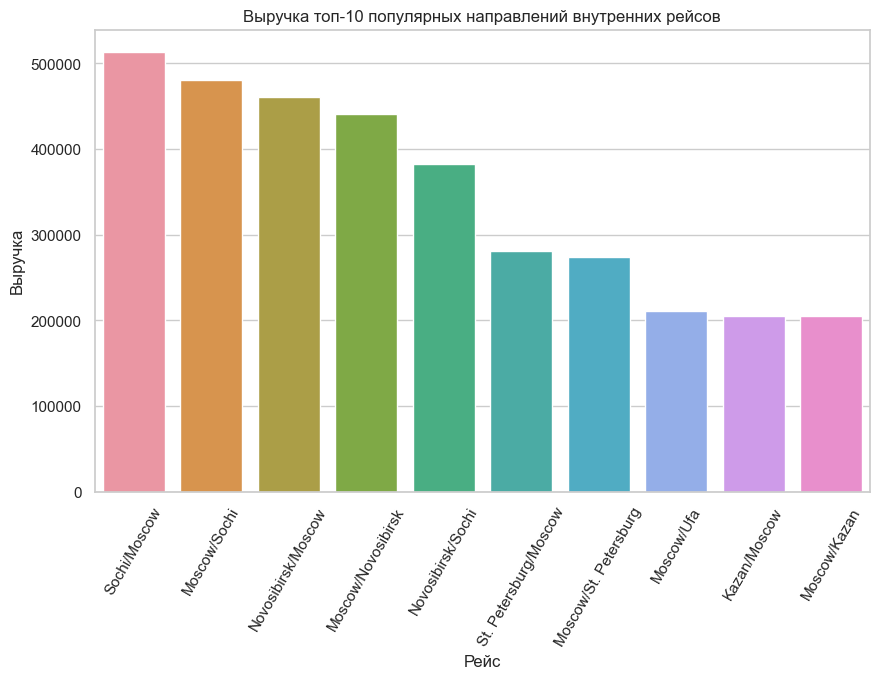

In [62]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_vvl, y='sum_revenue_amount', x='route').set(title='Выручка топ-10 популярных направлений внутренних рейсов',
                                                                               ylabel='Выручка',
                                                                              xlabel='Рейс')
plt.xticks(rotation=60)
plt.show()

Наибольшую выручку из этого топ-10 принес рейс Москва- Сочи, который был самым популярным напрвлением, наименьшую - Москва - Казань, оказавшийся на 7 месте по популярности и в силу невысокой стоимости билетов по вырчке закрыл десятку лидеров. 

Визуализируем этот-топ 10 на географической карте. 

In [63]:
#объединим координаты
good_df_1['geo_dep'] = good_df_1['lat_dep'].astype('str') + '/' +  good_df_1['lon_dep'].astype('str')
good_df_1['geo_des'] = good_df_1['lat_des'].astype('str') + '/' +  good_df_1['lon_des'].astype('str')
good_df_1['geo'] = good_df_1['geo_dep'] + '/' + good_df_1['geo_des']

In [64]:
#добавим координаты в топ-10
good_df_vvl = good_df_1[['route', 'geo']]
df_vvl = df_vvl.merge(good_df_vvl, on='route')
df_vvl = df_vvl.drop_duplicates()
df_vvl

,route,sum_revenue_amount,mean_revenue_amount,geo
0,Sochi/Moscow,513970,387.609351,43.449902/39.9566/55.972599/37.4146
1326,Moscow/Sochi,480480,371.888545,55.972599/37.4146/43.449902/39.9566
2618,Novosibirsk/Moscow,460720,476.442606,55.012599945068/82.650703430176/55.972599/37.4146
3585,Moscow/Novosibirsk,440440,466.567797,55.972599/37.4146/55.012599945068/82.650703430176
4529,Novosibirsk/Sochi,382470,572.559880,55.012599945068/82.650703430176/43.449902/39.9566
5197,St. Petersburg/Moscow,280870,231.932287,59.80030059814453/30.262500762939453/55.972599...
6408,Moscow/St. Petersburg,273720,230.016807,55.972599/37.4146/59.80030059814453/30.2625007...
7598,Moscow/Ufa,210610,297.471751,55.972599/37.4146/54.557498931885/55.874401092529
8306,Kazan/Moscow,205230,270.395257,55.606201171875/49.278701782227/55.972599/37.4146
9065,Moscow/Kazan,204660,270.356671,55.972599/37.4146/55.606201171875/49.278701782227


In [65]:
lat_dep = []
lon_dep = []
lat_des = []
lon_des = []
for i in df_vvl['geo']:
    lat_dep.append(float(i.split('/')[0]))
    lon_dep.append(float(i.split('/')[1]))
    lat_dep.append(float(i.split('/')[2]))
    lon_dep.append(float(i.split('/')[3])) 

In [66]:
pip install plotly

In [67]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [69]:
#построим географиечкую карту с маршрутами
fig = go.Figure(go.Scattermapbox(lat=lat_dep, lon=lon_dep))
fig.update_layout(mapbox_style="open-street-map")
fig.add_trace(go.Scattermapbox(mode = "lines",
                               hoverinfo='all',
                               lat=lat_dep[0:3:2],
                               lon=lon_dep[0:3:2]))  
fig.add_trace(go.Scattermapbox(mode = "lines",
                               hoverinfo='all',
                               lat=lat_dep[4:7:2],
                               lon=lon_dep[4:7:2]))
fig.add_trace(go.Scattermapbox(mode = "lines",
                               hoverinfo='all',
                               lat=lat_dep[8:10:1],
                               lon=lon_dep[8:10:1]))
fig.add_trace(go.Scattermapbox(mode = "lines",
                               hoverinfo='all',
                               lat=lat_dep[11:14:2],
                               lon=lon_dep[11:14:2]))
fig.add_trace(go.Scattermapbox(mode = "lines",
                               hoverinfo='all',
                               lat=lat_dep[15:18:2],
                               lon=lon_dep[15:18:2]))
fig.add_trace(go.Scattermapbox(mode = "lines",
                               hoverinfo='all',
                               lat=lat_dep[17:22:2],
                               lon=lon_dep[17:22:2]))
fig.show()

In [72]:
#создадим срез датасета по международным рейсам
mvl = good_df_1[good_df_1['route_flight_type'] == 'МВЛ']
#найдем топ-10 направлений по международным рейсам
mvl_10 = mvl['route'].value_counts().head(10)
mvl_10 = pd.DataFrame(mvl_10)
mvl_10

,route
Moscow/Osh,151
Khudzhand/Moscow,144
Osh/Moscow,136
Moscow/Khudzhand,129
Novosibirsk/Bishkek,120
Novosibirsk/Osh,119
Khudzhand/Novosibirsk,116
Osh/Novosibirsk,115
Bishkek/Novosibirsk,102
Moscow/Antalya,101


In [73]:
#сделаем срез, состоязий только из этих 10 направлений
mvl_10_ind = mvl_10.index.tolist()
good_df_mvl = good_df_1.query('route == @mvl_10_ind')
#посчитаем сумму и среднюю выручку для этого топ-10 по ВВЛ
df_mvl = good_df_mvl.pivot_table(index='route', aggfunc=['sum', 'mean'],values='revenue_amount').reset_index()
df_mvl.columns = ['route', 'sum_revenue_amount', 'mean_revenue_amount']
df_mvl = df_mvl.sort_values (by = ['sum_revenue_amount', 'mean_revenue_amount'], ascending=[False, False])
df_mvl

,route,sum_revenue_amount,mean_revenue_amount
1,Khudzhand/Moscow,95190,661.041667
8,Osh/Moscow,80920,595.000000
5,Moscow/Osh,68130,451.192053
2,Khudzhand/Novosibirsk,57740,497.758621
4,Moscow/Khudzhand,57710,447.364341
9,Osh/Novosibirsk,56980,495.478261
0,Bishkek/Novosibirsk,48300,473.529412
7,Novosibirsk/Osh,47450,398.739496
6,Novosibirsk/Bishkek,46980,391.500000
3,Moscow/Antalya,38080,377.029703


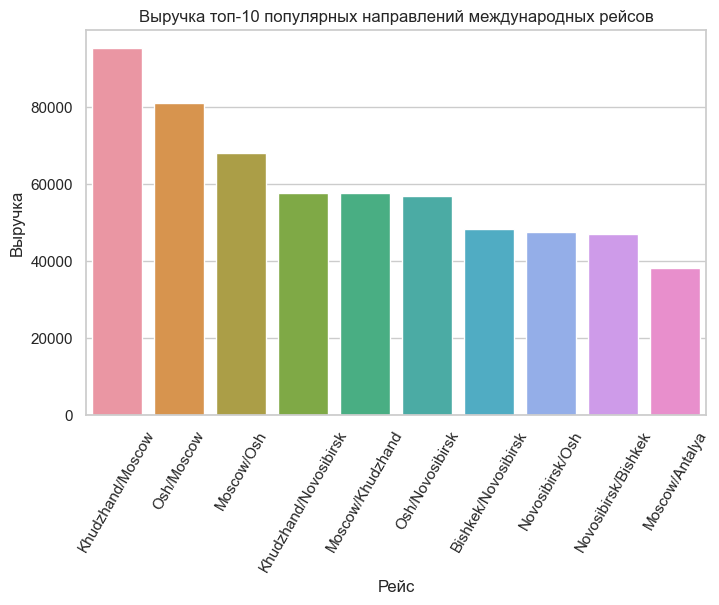

In [189]:
#построим столбчатую диаграмму по данной таблице
sns.barplot(data=df_mvl, y='sum_revenue_amount', x='route').set(title='Выручка топ-10 популярных направлений международных рейсов',
                                                                               ylabel='Выручка',
                                                                               xlabel='Рейс')
plt.xticks(rotation=60)
plt.show()

Как видим наибольшую выручку принес рейс Худжанд- Москва, занимающий второе место по популярности, наименьшую - Москва-Анталья, находящаяся и в аутсайдерах по популярности. 

Таким образом, почти все иностранные ресы, очевидно, совершаются через Москву и представляют собой авиасообщения со странами ближнего Зарубежья. Для внутренних рейсов Москва тоже становится центром ависообщений, причем ровно половина из топ-10 являлась вылетами из этого города, а другая часть обратными рейсами в Москву. 

### 3.6. Определите есть ли зависимость выручки от других признаков. Постройте матрицу корреляций.

In [197]:
#заменим Yes на 1, а  No на 1 для корреляции и изменим тип данных 
good_df['ffp_flag'] = good_df['ffp_flag'].replace({'Yes':1}, regex=True)
good_df['ffp_flag'] = good_df['ffp_flag'].replace({'No':0}, regex=True)
good_df[['sale_type', 'season', 'pax_type', 'month', 'route_flight_type']] = good_df[['sale_type', 'season', 'pax_type', 'month', 'route_flight_type']].apply(lambda x: pd.factorize(x)[0])
good_df

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type,year,month,month_year,season,difference_date
0,2021-12-07,2022-01-11,0,200,MOW,KGD,0,0,0,2021,0,2021-12-01,0,35
1,2021-12-31,2022-01-03,0,610,UUS,OVB,0,0,1,2021,0,2021-12-01,0,3
2,2021-11-28,2022-01-04,0,390,KGD,MOW,0,1,0,2021,1,2021-11-01,1,37
3,2021-12-08,2022-01-05,0,190,VOZ,MOW,0,0,0,2021,0,2021-12-01,0,28
4,2021-12-08,2022-01-12,0,190,MOW,KRR,0,1,1,2021,0,2021-12-01,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48370,2022-06-11,2022-06-22,1,480,MOW,OMS,0,0,0,2022,4,2022-06-01,2,11
48371,2022-06-06,2022-06-20,0,270,LED,MOW,0,0,1,2022,4,2022-06-01,2,14
48372,2022-06-26,2022-06-29,0,230,MOW,KZN,0,1,0,2022,4,2022-06-01,2,3
48373,2022-06-26,2022-06-28,0,270,KZN,MOW,0,0,1,2022,4,2022-06-01,2,2


In [200]:
#построим матрицу корреляции с помощью метода Кендалла, так как он используется для ненормального распределения и устойчив к выбросам
corr_df = good_df.corr(method='kendall')
corr_df = corr_df[['pax_type','revenue_amount', 'route_flight_type', 'ffp_flag','sale_type', 'year', 'month', 'season']]
corr_df = corr_df.drop(labels = ['difference_date'],axis = 0)
corr_df

,pax_type,revenue_amount,route_flight_type,ffp_flag,sale_type,year,month,season
pax_type,1.000000,-0.056646,0.040098,-0.161134,-0.052905,0.015561,-0.001012,0.029390
revenue_amount,-0.056646,1.000000,0.099217,-0.045901,0.129723,0.187455,0.107147,0.175823
route_flight_type,0.040098,0.099217,1.000000,-0.160406,0.105372,-0.121386,-0.092836,-0.104360
ffp_flag,-0.161134,-0.045901,-0.160406,1.000000,-0.321423,-0.026082,-0.018417,-0.007888
sale_type,-0.052905,0.129723,0.105372,-0.321423,1.000000,0.000200,0.006174,-0.010070
year,0.015561,0.187455,-0.121386,-0.026082,0.000200,1.000000,0.622239,0.440015
month,-0.001012,0.107147,-0.092836,-0.018417,0.006174,0.622239,1.000000,0.481591
season,0.029390,0.175823,-0.104360,-0.007888,-0.010070,0.440015,0.481591,1.000000


<AxesSubplot:>

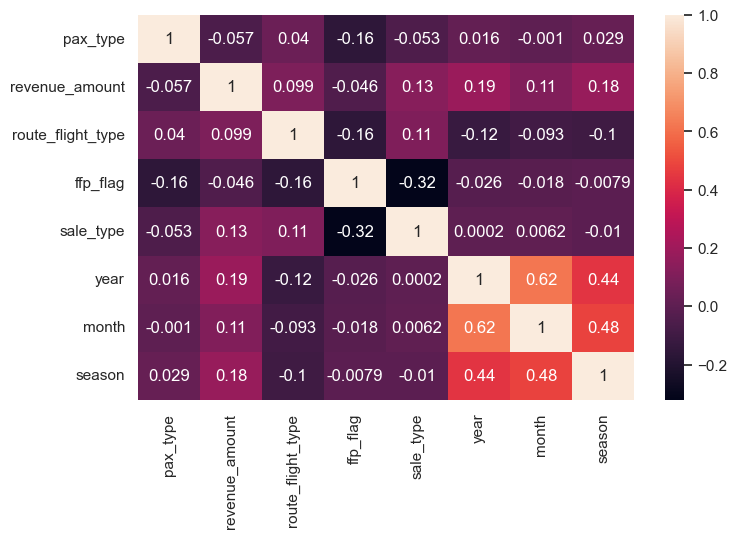

In [201]:
sns.heatmap(corr_df, annot=True)

По матрице корреляций и тепловой карте (второму столбцу), мы можем заметить, что между всеми факторами и выручкой авикомпании связь очень слабая. Для типа рейса (ВВЛ/МВЛ), типа покупки билета, года, месяца и сезона связь остается прямой, а для наличия программы лояльности свзяь обратная, типа билета. Самой тесной среди них явлется связь между выручкой и годом ее получения, но и то по шкале Чеддока эта связь едва заметна. 